In [1]:
#Inserindo caminho da pasta onde estão os modulos que utilizaremos
import sys
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
sys.path.insert(0, r"C:\Users\Ari\Documents\UFAL\Pesquisa\PIBIC 23-24\Dados\LIB INPE\modulos_tratamento_dados\modulos_tratamento_dados\modulos")

#Importando os módulos
import modulo1_station_processing as modulo1 
import modulo2_statistics as modulo2
import modulo3_stations_virtual as modulo3


In [2]:
#importando funções
import os
import glob
from shapely import Point

#============================================================================================================
#                               FUNÇÕES PARA EXTRAIR NOMES DOS ARQUIVOS (SATÉLITE) 
#============================================================================================================


def filter_annual_path(path, year=2019, name_extension_file='grib2'):
    ''' Seleciona o nome das pastas com dados diários para um ano especificado '''

    list_path = glob.glob(os.path.join(path, "*." + str(name_extension_file))) 
    list_path = [path for path in list_path if str(year) in path]

    return list_path

def filter_range_annual_path(path, year_start=2019, year_end=2020, name_extension_file='grib2'):
    ''' Seleciona o nome das pastas com dados para um intervalo de anos especificado '''
    
    list_path = [path_name for year in range(year_start, year_end + 1) 
                 for path_name in filter_annual_path(path, year, name_extension_file)]
    
    return list_path

def filter_month_path(path, month=202001, name_extension_file='grib2'):
    ''' Seleciona um mês de um ano específico '''

    list_path = glob.glob(os.path.join(path, "*." + str(name_extension_file))) 
    list_path = [path for path in list_path if str(month) in path]

    return list_path

#============================================================================================================
#                             FUNÇÕES PARA EXTRAIR SÉRIES TEMPORAIS DE UM ÚNICO PIXEL
#============================================================================================================

def prec_series_grib(x_point, y_point, list_path, temporal_scaling='dailly_rain'):

    ''' Gera uma série de dados para um ponto específico do arquivo grib
    x_point: coodenada x do ponto de interesse dos dados de setélite
    y_point: coordenada y do ponto de interesse
    list_path: lista com a pasta de de cada arquivo que desejamos realizar a leitur '''

    #Criando dataframe para armazenar dados
    df_prec = gpd.GeoDataFrame(columns=['prec', 'Date'])

    #Apenas criando duas listas, cada uma para armazenar valores de precipitação e a data
    list_prec, list_date = [], []
        
    #Lendo arquivo com dados de um único dia, porém em diversos pontos 
    list_prec_day = [modulo3.read_file_precipitation_grib(path, temporal_scaling=temporal_scaling) for path in list_path]

    #Selecionando o valor de um ponto específico
    list_filter_point = [prec_day[(np.around(prec_day.geometry.x, 2) == x_point) & (np.around(prec_day.geometry.y, 2) == y_point)] for prec_day in list_prec_day]

    #Adicionando a lista os valores de precipitação e a data
    prec = [filter_point.prec.to_list()[0] for filter_point in list_filter_point]
    list_prec.append(prec)

    date = [filter_point.time.to_list()[0] for filter_point in list_filter_point]
    list_date.append(date)

    #Acrescentando ao dataframe
    df_prec['prec'], df_prec['Date'] = list_prec, list_date

    return df_prec 


#============================================================================================================
#                         FUNÇÕES PARA CALCULAR INTERPOLAÇÃO BILINEAR DOS ARQUIVOS (SATÉLITE) 
#                                           (comparação PIXEL Ponto)
#============================================================================================================

def calc_interpolation_series(coords_station, list_name_files, df_station, temp_scale='dailly_rain'):

    #Guardando em uma lista os valores
    values_station = df_station['Precipitação (mm)'].to_list()

    #Armazenando coordenadas da estação
    station_real = gpd.GeoDataFrame(geometry=[Point(coords_station)]) 

    #Lista para guardar resultado dos valores interpolados
    values_interpolation = [] 

    #Realizando leitura do arquivo
    list_df_prec = [modulo3.read_file_precipitation_grib(path_data, temporal_scaling=temp_scale) for path_data in list_name_files]
    
    #Procurando as 4 estaçõs virtuais mais próximas
    list_stations_virtual = [modulo3.find_station_virtual(df_prec, station_real.geometry[0]) for df_prec in list_df_prec]
    
    #Selecionando lista com estações e ponto de interesse (estação Traipu)
    list_stations = [modulo3.organizing_stations(stations_virtual) for stations_virtual in list_stations_virtual]

    #Calculando interpolação bilinear para as coordenadas da estação de Traipu
    prec_interpolation = [modulo3.bilinear_interpolation(coords_station, stations) for stations in list_stations]
    
    return values_station, prec_interpolation 

In [3]:
#Importanddo função para unir diversas geometrias 
from shapely.ops import cascaded_union, unary_union

#Leitura rquivo região de interesse (semiarido)
semiarido = gpd.read_file(r"C:\Users\Ari\Documents\UFAL\Pesquisa\PIBIC 23-24\Dados\semiarido_2021\semiarido_2021.shp", crs='EPSG:4326')

#Vamos excluir os municípios que não fazem parte do Semiárido e unir a geometria ds demais, para termos uma única
semiarido_union = unary_union(semiarido[semiarido.Situacao != 'Excluído - Em contestação'].geometry)
semiarido_union = gpd.GeoDataFrame(geometry = [semiarido_union], crs='EPSG:4326')


In [4]:
#Lendo arquivo de uma estação qualquer, neste caso, de Traipú
path = r'C:\Users\Ari\Documents\UFAL\Pesquisa\PIBIC 23-24\Dados\Dados_estações\TRAIPU (1).xlsx'
df_traipu = modulo1.read_station(path)

path1 = r'C:\Users\Ari\Documents\UFAL\Pesquisa\PIBIC 23-24\Dados\Dados_estações\PENEDO (1).xlsx'
df_penedo = modulo1.read_station(path1)

df_penedo.head()

Data  Precipitação (mm)
ID          geometry                                              
ANA_1036005 POINT (-10.285 -36.5564) 1935-01-01                0.0
            POINT (-10.285 -36.5564) 1935-01-02                0.0
            POINT (-10.285 -36.5564) 1935-01-03                0.0
            POINT (-10.285 -36.5564) 1935-01-04                0.0
            POINT (-10.285 -36.5564) 1935-01-05                0.0

In [5]:
#Filtrando os dados da estação para uma data específica
range_data = df_penedo[(df_penedo.Data >= "2001-01-01") & (df_penedo.Data <= "2018-12-31")]

#Calculando acumulados mensais para um único ano
penedo_month_accum = modulo2.month_statistics(range_data, opc=0)
penedo_month_accum = penedo_month_accum[penedo_month_accum.index != '2009-06-30']

In [7]:
path_monthly = r'C:\Users\Ari\Documents\UFAL\Pesquisa\PIBIC 23-24\Dados\LIB INPE\modulos_tratamento_dados\modulos_tratamento_dados\dados\MONTHLY_ACCUM_MANUAL'

files = filter_range_annual_path(path_monthly, year_start=2001, year_end=2018, name_extension_file='nc') 

traipu_month_accum = penedo_month_accum[(penedo_month_accum.index.year >= 2001) & (penedo_month_accum.index.year <= 2018)]

coords_station = (-10.285, -36.5564)

interpolation_penedo = calc_interpolation_series(coords_station, files, penedo_month_accum, temp_scale='monthly_accum_manual')

C:\Users\Ari\Documents\UFAL\Pesquisa\PIBIC 23-24\Dados\LIB INPE\modulos_tratamento_dados\modulos_tratamento_dados\modulos\modulo3_stations_virtual.py:194: RuntimeWarning: divide by zero encountered in scalar divide
  fR1 = (f1*(x2 - x)/(x2 - x1)) + (f2*(x - x1)/(x2 - x1))
C:\Users\Ari\Documents\UFAL\Pesquisa\PIBIC 23-24\Dados\LIB INPE\modulos_tratamento_dados\modulos_tratamento_dados\modulos\modulo3_stations_virtual.py:194: RuntimeWarning: invalid value encountered in scalar add
  fR1 = (f1*(x2 - x)/(x2 - x1)) + (f2*(x - x1)/(x2 - x1))
C:\Users\Ari\Documents\UFAL\Pesquisa\PIBIC 23-24\Dados\LIB INPE\modulos_tratamento_dados\modulos_tratamento_dados\modulos\modulo3_stations_virtual.py:195: RuntimeWarning: divide by zero encountered in scalar divide
  fR2 = (f3*(x2 - x)/(x2 - x1)) + (f4*(x - x1)/(x2 - x1))
C:\Users\Ari\Documents\UFAL\Pesquisa\PIBIC 23-24\Dados\LIB INPE\modulos_tratamento_dados\modulos_tratamento_dados\modulos\modulo3_stations_virtual.py:195: RuntimeWarning: invalid value 

In [9]:
from shapely import Point

In [39]:
gdf[gdf.geometry == ]


,time,step,surface,spatial_ref,prec,geometry
0,2002-04-01 12:00:00,0 days,0.0,0,112.375,POINT (-120.05000 -60.05000)
1,2002-04-01 12:00:00,0 days,0.0,0,74.000,POINT (-119.95000 -60.05000)
2,2002-04-01 12:00:00,0 days,0.0,0,75.500,POINT (-119.85000 -60.05000)
3,2002-04-01 12:00:00,0 days,0.0,0,73.375,POINT (-119.75000 -60.05000)
4,2002-04-01 12:00:00,0 days,0.0,0,81.625,POINT (-119.65000 -60.05000)
...,...,...,...,...,...,...
924919,2002-04-01 12:00:00,0 days,0.0,0,11.500,POINT (-20.45000 32.25000)
924920,2002-04-01 12:00:00,0 days,0.0,0,16.875,POINT (-20.35000 32.25000)
924921,2002-04-01 12:00:00,0 days,0.0,0,23.625,POINT (-20.25000 32.25000)
924922,2002-04-01 12:00:00,0 days,0.0,0,24.250,POINT (-20.15000 32.25000)


In [38]:
path_monthly = r'C:\Users\Ari\Documents\UFAL\Pesquisa\PIBIC 23-24\Dados\LIB INPE\modulos_tratamento_dados\modulos_tratamento_dados\dados\MONTHLY_ACCUM_MANUAL\MERGE_CPTEC_acum_apr_2002.nc'

gdf = modulo3.read_file_precipitation_grib(path_monthly, temporal_scaling='monthly_accum_manual')

point_of_interest = Point(-120.05000, -60.05000)

possible_matches_index = list(gdf.sindex.intersection(point_of_interest.bounds))
possible_matches = gdf.iloc[possible_matches_index]

precise_matches = possible_matches[possible_matches.intersects(point_of_interest)]
precise_matches.head()

,time,step,surface,spatial_ref,prec,geometry


In [44]:
point_of_interest = Point((-120.05000, -60.05000))
gdf[gdf.geometry == point_of_interest]


,time,step,surface,spatial_ref,prec,geometry


In [45]:
gdf.geometry

0         POINT (-120.05000 -60.05000)
1         POINT (-119.95000 -60.05000)
2         POINT (-119.85000 -60.05000)
3         POINT (-119.75000 -60.05000)
4         POINT (-119.65000 -60.05000)
                      ...             
924919      POINT (-20.45000 32.25000)
924920      POINT (-20.35000 32.25000)
924921      POINT (-20.25000 32.25000)
924922      POINT (-20.15000 32.25000)
924923      POINT (-20.05000 32.25000)
Name: geometry, Length: 924924, dtype: geometry

In [27]:
gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [26]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

# Exemplo de dataframe
data = {
    'id': [1, 2, 3],
    'value': [10, 20, 30],
    'latitude': [-23.5505, -22.90350, -21.7645],
    'longitude': [-46.6333, -43.20960, -41.3393]
}

df = pd.DataFrame(data)

# Criar uma coluna de geometria
df['geometry'] = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]

# Transformar em GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry='geometry')

# Definir o sistema de coordenadas (WGS84)
gdf.set_crs(epsg=4326, inplace=True)

# Coordenadas do ponto de interesse
point_of_interest = Point(-43.2096, -22.9035)

# Criar um índice espacial
gdf.sindex

# Filtrar a linha correspondente ao ponto de interesse usando o índice espacial
possible_matches_index = list(gdf.sindex.intersection(point_of_interest.bounds))
possible_matches = gdf.iloc[possible_matches_index]

precise_matches = possible_matches[possible_matches.intersects(point_of_interest)]

print(precise_matches)

   id  value  latitude  longitude                     geometry
1   2     20  -22.9035   -43.2096  POINT (-43.20960 -22.90350)


In [22]:
precise_matches

,time,step,surface,spatial_ref,prec,geometry


In [14]:
point_of_interest.bounds

(-10.285, -36.5564, -10.285, -36.5564)

In [ ]:
data_station, data_interpolation = interpolation_penedo[0], interpolation_penedo[1]

penedo = gpd.GeoDataFrameFrame()

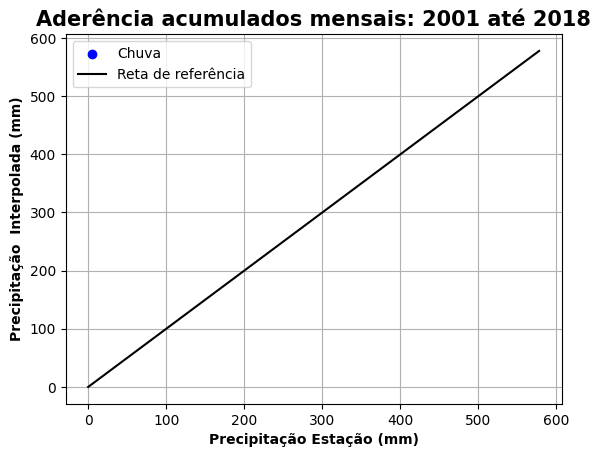

In [9]:

data_station, data_interpolation = interpolation_penedo[0], interpolation_penedo[1]

prec_month_accum_max = max(penedo_month_accum['Precipitação (mm)'].to_list())

fig, ax = plt.subplots()

ax.scatter(np.array(data_station), np.array(data_interpolation), color='blue')
ax.plot([0, prec_month_accum_max], [0, prec_month_accum_max], color='black')

plt.title('Aderência acumulados mensais: 2001 até 2018', size=15, weight='bold')
plt.xlabel('Precipitação Estação (mm)', size=10, weight='bold')
plt.ylabel('Precipitação  Interpolada (mm)', size=10, weight='bold')
plt.legend(['Chuva', 'Reta de referência'])
plt.grid()

plt.show()

In [11]:
data_interpolation

[nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan